In [45]:
import pandas as pd



## VALUATIONS

In [46]:
# Read valuations
valuations_path = 'datasets/player_valuations.csv'

# Read the CSV file into a pandas DataFrame
df_val = pd.read_csv(valuations_path)

#drop unesseccary columns
df_val = df_val.drop(columns=["datetime", "dateweek"])


## CONSTANTS

In [47]:
#Get latest season end year
latest_date = df_val['date'].max()
latest_year = int(latest_date[0:4])
latest_year

MONTH_START = "-08-10"
MONTH_END = "-06-10"

## PLAYER STATS

In [48]:
# Read stats
"""
Columns
appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
"""
stats_path = 'datasets/appearances.csv'

# Read the CSV file into a pandas DataFrame
df_stats = pd.read_csv(stats_path)

#drop unesseccary columns
#TBD

## CATEGORICAL DATA

In [49]:
"""
CATEGORICAL DATA HANDLING
Columns
player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
"""

# Read player categorical data
categorical_path = 'datasets/players.csv'

df_categorical = pd.read_csv(categorical_path)

#drop redundant columns
#comment: dropping sub-position as all players only have one
df_cat = df_categorical.drop(
    columns=[
        "first_name", "last_name", "name", "player_code", "city_of_birth", "image_url", "url", "highest_market_value_in_eur", "current_club_name",
        "agent_name", "current_club_domestic_competition_id", "market_value_in_eur", "current_club_domestic_competition_id", "current_club_id", "last_season", "sub_position"
        ])


#Change date of birth to age
df_cat['date_of_birth'] = pd.to_datetime(df_cat['date_of_birth'])
def calculate_age(birthdate):
    today = pd.to_datetime('today')
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age

df_cat['age'] = df_cat['date_of_birth'].apply(calculate_age)

#date of birth now redundant
df_cat = df_cat.drop(columns=["date_of_birth"])


# Fill NaN values in 'height_in_cm' with the mean
mean_value = df_cat['height_in_cm'].mean()
df_cat['height_in_cm'].fillna(mean_value, inplace=True)

#Fill NaN values in col Foot with 'right'
most_frequent_value = df_cat['foot'].mode().iloc[0]
df_cat['foot'].fillna(most_frequent_value, inplace=True)

## CLUB GAMES

In [50]:
"""
Club games data handling
Columns: game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win
"""

# Read player categorical data
club_games_path = 'datasets/club_games.csv'
game_lineups_path = 'datasets/game_lineups.csv'
games_path = 'datasets/games.csv'


df_club_games = pd.read_csv(club_games_path)
df_game_lineups = pd.read_csv(game_lineups_path)
df_games = pd.read_csv(games_path)


# Use boolean indexing to filter the DataFrame
game_ids_last_season = df_games[(df_games['date'] >= str(latest_year-1) + MONTH_START) & (df_games['date'] <= str(latest_year) + MONTH_END)]

# Get the game_id values for the filtered DataFrame
game_ids_in_range = game_ids_last_season['game_id'].tolist()

df_club_games_last_season = df_club_games[df_club_games['game_id'].isin(game_ids_in_range)]
df_game_line_ups_last_season = df_game_lineups[df_game_lineups['game_id'].isin(game_ids_in_range)]

df_club_games_last_season

/var/folders/c_/1y6gr31n0mb2wc726nybkxg80000gn/T/ipykernel_9260/139413451.py:13: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_game_lineups = pd.read_csv(game_lineups_path)


,game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win
3524,3825466,418,2,NaN,Carlo Ancelotti,24,0,NaN,Oliver Glasner,Home,1
3529,3828437,678,1,3.0,Uwe Rösler,369,0,10.0,Freyr Alexandersson,Home,1
3530,3828449,2414,2,6.0,Jens Berthel Askou,678,1,4.0,Uwe Rösler,Home,1
3531,3828459,865,0,8.0,Albert Capellas,1053,2,10.0,Lars Friis,Home,0
3532,3828483,2414,0,8.0,Jens Berthel Askou,1053,0,11.0,Erik Hamrén,Home,0
...,...,...,...,...,...,...,...,...,...,...,...
130634,4072488,36,3,3.0,NaN,7775,0,19.0,NaN,Away,1
130635,4072493,7775,0,19.0,NaN,589,3,12.0,NaN,Away,0
130636,4080529,46,2,NaN,Simone Inzaghi,430,1,NaN,Vincenzo Italiano,Away,1
130839,4001330,131,3,NaN,Xavi,418,1,NaN,Carlo Ancelotti,Away,1


## EDA / DATA HANDLING

Fix contract_expiration

In [51]:
#Change contract expiration date to see how many months they have left at end of season
df_cat['contract_expiration_date'] = pd.to_datetime(df_cat['contract_expiration_date'])

current_date = pd.to_datetime(str(latest_year) + MONTH_END) #get latest date we are looking at

# Calculate the difference in months between the contract expiration date and the current date
# Calculate the difference in days first
df_cat['days_left'] = (df_cat['contract_expiration_date'] - current_date).dt.days.fillna(0)

# Convert days to months by dividing by the average number of days per month
# The average number of days in a month is approximately 30.44
df_cat['months_left'] = df_cat['days_left'] / 30.44

# Optional: If you want to round to the nearest whole number
df_cat['months_left'] = df_cat['months_left'].round().astype(int)

#contract expiration now redundant
df_cat = df_cat.drop(columns=["contract_expiration_date", "days_left"])

# Set negative values to zero because there will be some outgoing contracts at end of seasons
df_cat['months_left'] = df_cat['months_left'].clip(lower=0)

Only use last season and top 5 leagues in the world

In [52]:
#Select only specific leagues
competition_column = 'player_club_domestic_competition_id'
competitions = ["IT1", "GB1", "FR1", "L1", "ES1"]

#Take values from only last season
date_column = "date"
max_date_last_season = str(latest_year) + MONTH_END
min_date_last_season = str(latest_year-1) + MONTH_START

# Create a new DataFrame containing only rows where the 'column_name' matches the 'desired_value'
df_val_last_season = df_val[(df_val[competition_column].isin(competitions)) 
                                 & (df_val[date_column] >= min_date_last_season)
                                 & (df_val[date_column] <= max_date_last_season)]

df_stats_last_season = df_stats[(df_stats[date_column] >= min_date_last_season)
                                 & (df_stats[date_column] <= max_date_last_season)]

#Sort based on date
df_sorted = df_val_last_season.sort_values(by=['player_id', 'date'], ascending=[True, False])

# Drop duplicates, keeping the first entry for each 'playerID'
df_latest_valuations_last_season = df_sorted.drop_duplicates(subset='player_id', keep='first')

Select club game wins last season only

In [53]:
#aggregate stats for last season
df_aggregated_club_games= df_club_games_last_season.groupby('club_id').agg({
    'own_goals': 'sum',
    'opponent_goals': 'sum',
    'is_win': 'sum'
}).reset_index()


df_aggregated_club_games['current_club_id'] = df_aggregated_club_games['club_id']

df_aggregated_club_games = df_aggregated_club_games.drop(columns=["club_id"])


Aggregate stats for each player over the specific season

In [54]:
#aggregate stats for last season
df_aggregated_stats_last_season = df_stats_last_season.groupby('player_id').agg({
    'yellow_cards': 'sum',
    'red_cards': 'sum',
    'goals': 'sum',
    'assists': 'sum',
    'minutes_played': 'sum',
    'player_name': 'first' 
}).reset_index()

In [55]:
"""
STATS DATA HANDLING
"""

#df_aggregated_stats_last_season = df_aggregated_stats_last_season.drop(columns=["yellow_cards"])

'\nSTATS DATA HANDLING\n'

Merge all dataframes together

In [56]:
#Merge all dataframes together
df_val_stats_last_season = pd.merge(df_latest_valuations_last_season, df_aggregated_stats_last_season, on='player_id', how='inner')
df_val_stats_cat_last_season = pd.merge(df_val_stats_last_season, df_cat, on='player_id', how="inner")
df_features = pd.merge(df_val_stats_cat_last_season, df_aggregated_club_games, on='current_club_id', how="inner")



## Final columns

In [57]:
df_features

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id,yellow_cards,red_cards,goals,assists,minutes_played,...,country_of_birth,country_of_citizenship,position,foot,height_in_cm,age,months_left,own_goals,opponent_goals,is_win
0,3333,2022-11-03,2000000,1237,GB1,3,0,0,2,1238,...,England,England,Midfield,right,175.0,37.0,13,98,66,23
1,43530,2022-11-03,1500000,1237,GB1,0,0,3,1,759,...,England,England,Midfield,both,172.0,35.0,13,98,66,23
2,67063,2022-11-03,8000000,1237,GB1,0,0,7,3,2053,...,England,England,Attack,right,185.0,33.0,13,98,66,23
3,73564,2023-03-16,1000000,1237,GB1,1,0,0,1,1890,...,England,England,Goalkeeper,right,188.0,33.0,37,98,66,23
4,82873,2022-11-03,8000000,1237,GB1,6,0,8,10,3762,...,Germany,Germany,Midfield,right,181.0,32.0,25,98,66,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,533662,2023-06-01,12000000,350,GB1,0,0,0,0,65,...,England,England,Attack,right,175.0,22.0,49,12,10,4
2711,546712,2022-11-14,3500000,350,GB1,3,0,2,1,869,...,Denmark,Tunisia,Midfield,both,188.0,22.0,37,12,10,4
2712,554251,2023-03-27,3500000,350,GB1,1,0,1,1,1716,...,Algeria,Algeria,Defender,left,176.0,22.0,13,12,10,4
2713,663581,2022-11-07,7000000,350,GB1,12,0,1,1,2665,...,Brazil,Brazil,Midfield,right,187.0,24.0,49,12,10,4


Analysis on wether the feature affects the valuation or not

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

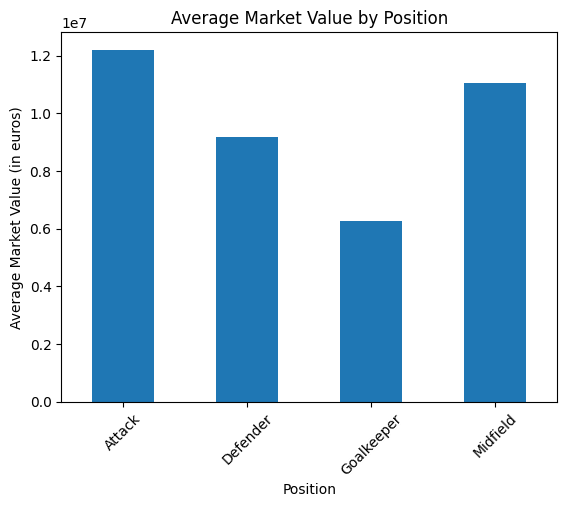

In [59]:
df_features = df_features[df_features['position'] != "Missing"]
grouped_data = df_features.groupby('position')['market_value_in_eur'].mean()

# Plotting
grouped_data.plot(kind='bar')
plt.title('Average Market Value by Position')
plt.xlabel('Position')
plt.ylabel('Average Market Value (in euros)')
plt.xticks(rotation=45)  # Rotates the labels on x-axis for better readability
plt.show()

Positions obviousley affects market value and will be accounted for in the model.

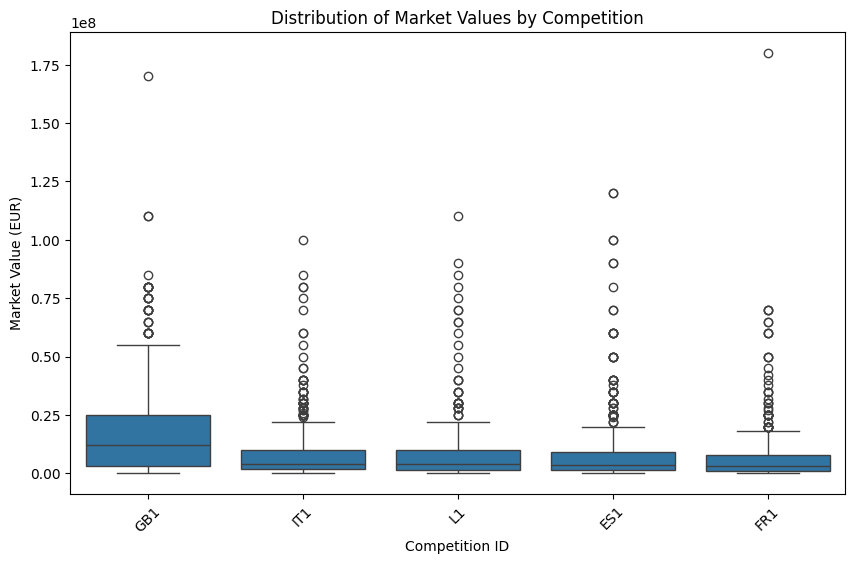

In [60]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='player_club_domestic_competition_id', y='market_value_in_eur', data=df_features)

plt.xlabel('Competition ID')
plt.ylabel('Market Value (EUR)')
plt.title('Distribution of Market Values by Competition')
plt.xticks(rotation=45)  # Rotates the labels on x-axis for better readability

plt.show()

GB1 has a relatively wide interquartile range, indicating a larger variation in market values compared to other competitions.
All competitions have outliers above the upper whisker, indicating some players with market values significantly higher than the general population within those competitions.
The median line within each box can give you an idea of the central tendency of market values within each competition.

Which league the player plays in is therefore relevant for the market value.

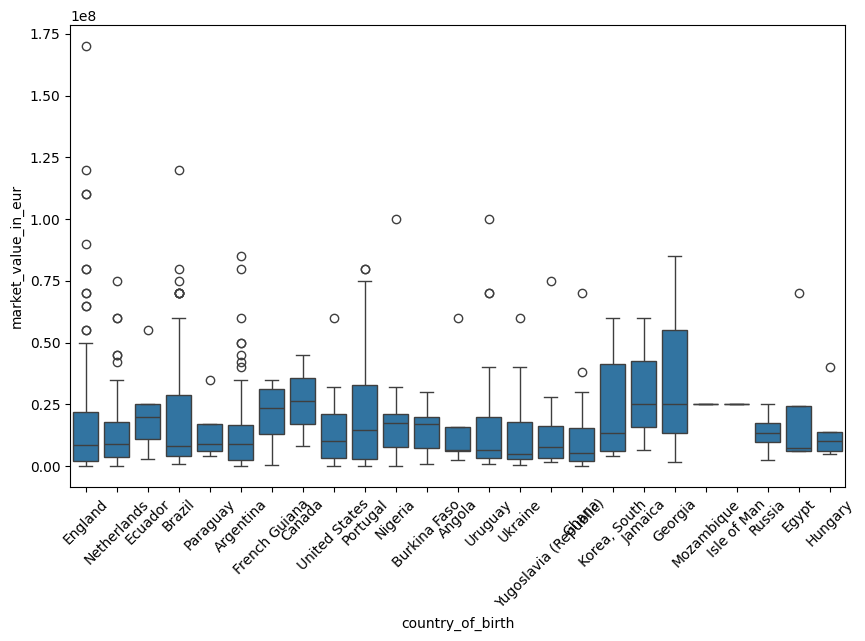

In [68]:
# Group by country of birth and get the average market value
country_market_values = df_features.groupby('country_of_birth')['market_value_in_eur'].mean().sort_values(ascending=False)

# Take the top N countries
top_countries = country_market_values.head(25)  # Adjust N as needed

# Filter the original DataFrame to include only the top N countries
top_countries_df = df_features[df_features['country_of_birth'].isin(top_countries.index)]

# Now plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='country_of_birth', y='market_value_in_eur', data=top_countries_df)
plt.xticks(rotation=45)
plt.show()

Very random and it seems like country of birth is wrong. Dropping column...

In [72]:
# Assuming df_features is your original DataFrame

# Group by league and find the player with the highest market value in each league
highest_valued_players = df_features.loc[df_features.groupby('player_club_domestic_competition_id')['market_value_in_eur'].idxmax()]

# Select only relevant columns, such as player name, league, and market value
highest_valued_players = highest_valued_players[['player_name', 'country_of_birth', 'player_club_domestic_competition_id', 'market_value_in_eur']]

# Reset index to clean up the DataFrame if necessary
highest_valued_players.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(highest_valued_players)

       player_name country_of_birth player_club_domestic_competition_id  \
0  Vinicius Junior           Brazil                                 ES1   
1    Kylian Mbappé           France                                 FR1   
2   Erling Haaland          England                                 GB1   
3   Victor Osimhen          Nigeria                                 IT1   
4    Jamal Musiala          Germany                                  L1   

   market_value_in_eur  
0            120000000  
1            180000000  
2            170000000  
3            100000000  
4            110000000  
